In [1]:
from SimPEG import *
import simpegEM as EM # on dev branch
from scipy.constants import mu_0
from pymatsolver import MumpsSolver
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Model Parameters

In [11]:
# Model Resistivities (Ohm-m) 
rhoback = 10. # background
rhoair = 1e8 # air
rhoreservoir = 1. #reservoir layer
rhocasing = 1./5.5e6 # conductivity of carbon steel
rhoinside = 1. # conductivity of fluid filling well (Commer et al uses 0.3333 S/m)

# relative permeability (only of casing --> the rest is mu_0) 
murback = 1. 
murcasing = 100. # permeability of casing

# depths (air-earth interface at 0, z-positive up) 
zreservoir = [-1000., -950.]
zcasing = [-1050., 0.]

# casing parameters
d = 10e-2 # 10cm diameter casing
t = 1e-2  # 1cm thickness 
casing_a = d/2.
casing_b = d/2. + t

# Survey Params
freqs = [1.,10.] 
dsz = -1000. # down-hole z source location

print 'Skin Depth: ', [(500./np.sqrt(1./rhoback*_)) for _ in freqs]

Skin Depth:  [1581.1388300841895, 500.0]


# Mesh

1687360


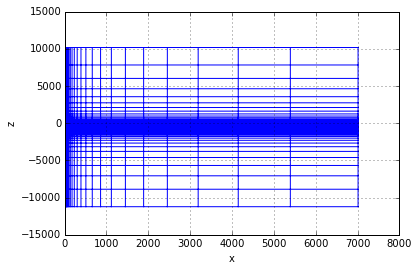

In [12]:
csx,csz = 2.5e-3, 0.05 # core cell size in x,z directions
ncx, npadxi, npadxo = np.ceil((d/2.+t)/csx+5), 0, 51 # number of core cells, number of padding cells in the x- direction
ncz, npadzu, npadzd = np.ceil(-zcasing[0]/csz+10), 41, 41 # number of core cells, number of padding cells in the x- direction

hx = Utils.meshTensor([(csx,ncx), (csx,npadxo,1.3)]) # vector of cell widths in the x-direction
hz = Utils.meshTensor([(csz,npadzd,-1.3), (csz,ncz), (csz,npadzu,1.3)]) # vector of cell widths in the z-direction
meshp = Mesh.CylMesh([hx,1,hz], [0.,0.,-np.sum(hz[:npadzu+ncz-5])]) # define the cylindrical mesh

# Plot the Mesh
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
meshp.plotGrid(ax=ax)
# ax.axis([0., 0.2,-1500., 3.])

print meshp.nC

# Put Model on Mesh

In [13]:
# background
RhoBack = rhoback*np.ones((meshp.nC)) # primary sigma on primary mesh  
MuBack  = murback*np.ones((meshp.nC)) # primary mur on primary mesh

# air
iAir          = meshp.gridCC[:,2] >= 0.
RhoBack[iAir] = rhoair
 
# reservoir layer
RhoReservoir = RhoBack.copy()
iReservoirZ = (meshp.gridCC[:,2]>=zreservoir[0]) & (meshp.gridCC[:,2]<=zreservoir[1])
RhoReservoir[iReservoirZ] = rhoreservoir


RhoBackCasing = RhoBack.copy()
RhoReservoirCasing = RhoReservoir.copy()
MuCasing = MuBack.copy()

# Inside casing
iInsideX = meshp.gridCC[:,0] < d/2.
iInsideZ = (meshp.gridCC[:,2] >= zcasing[0]) & (meshp.gridCC[:,2] <= zcasing[1])
iInside = iInsideX & iInsideZ
RhoBackCasing[iInside] = rhoinside
RhoReservoirCasing[iInside] = rhoinside

# Casing
iCasingX = (meshp.gridCC[:,0] >= d/2.) & (meshp.gridCC[:,0] <= d/2.+t)
iCasingZ = iInsideZ
iCasing = iCasingX & iCasingZ
RhoBackCasing[iCasing] = rhocasing
RhoReservoirCasing[iCasing] = rhocasing

MuCasing[iCasing] = murcasing

# use mu not mur 
MuBack   = mu_0*MuBack
MuCasing = mu_0*MuCasing

[]

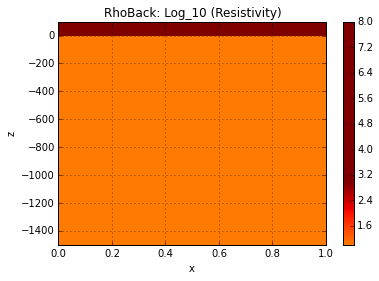

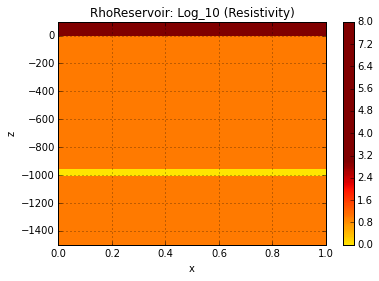

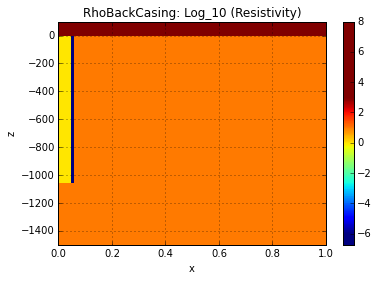

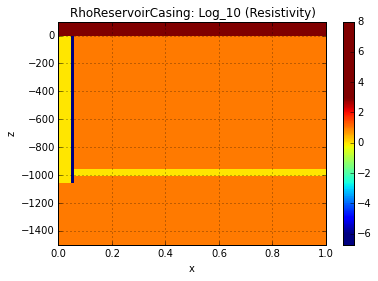

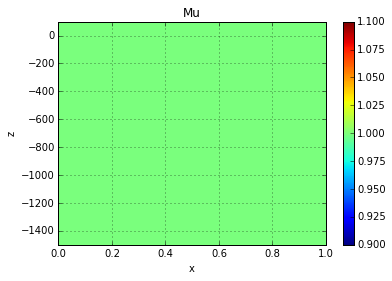

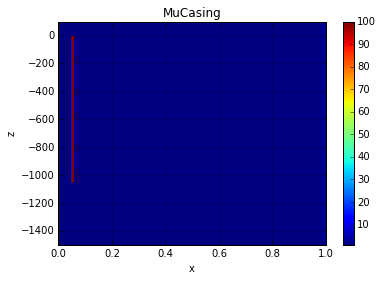

In [14]:
# Plot Resistivity Model : note cyl symmetric mesh: rotate around r = 0
xlim = [0., 1.]
ylim = [-1500., 100.]
clim = [-6.,3.]

# rhoback
f = plt.colorbar(meshp.plotImage(np.log10(RhoBack))[0])
f.set_clim(clim[0],clim[1])
plt.xlim(xlim)
plt.ylim(ylim)
plt.grid(which='both')
plt.title('RhoBack: Log_10 (Resistivity)')
plt.plot()

# rhoNoCO2NoCasing
f = plt.colorbar(meshp.plotImage(np.log10(RhoReservoir))[0])
f.set_clim(clim[0],clim[1])
plt.xlim(xlim)
plt.ylim(ylim)
plt.grid(which='both')
plt.title('RhoReservoir: Log_10 (Resistivity)')
plt.plot()

# rhoNoCO2
f = plt.colorbar(meshp.plotImage(np.log10(RhoBackCasing))[0])
f.set_clim(clim[0],clim[1])
plt.xlim(xlim)
plt.ylim(ylim)
plt.grid(which='both')
plt.title('RhoBackCasing: Log_10 (Resistivity)')
plt.plot()

# rhoCO2NoCasing
f = plt.colorbar(meshp.plotImage(np.log10(RhoReservoirCasing))[0])
f.set_clim(clim[0],clim[1])
plt.xlim(xlim)
plt.ylim(ylim)
plt.grid(which='both')
plt.title('RhoReservoirCasing: Log_10 (Resistivity)')
plt.plot()


# Plot Rel Permeability Model
plt.colorbar(meshp.plotImage(MuBack/mu_0)[0])
plt.xlim(xlim)
plt.ylim(ylim)
plt.grid(which='both')
plt.title('Mu')
plt.plot()

# Plot Rel Permeability Model
plt.colorbar(meshp.plotImage(MuCasing/mu_0)[0])
plt.xlim(xlim)
plt.ylim(ylim)
plt.grid(which='both')
plt.title('MuCasing')
plt.plot()

# Survey

In [15]:
# point sources
src_loc = np.r_[0.,0.,dsz]
s_ind = Utils.closestPoints(meshp,src_loc,'Fz') + meshp.nFx

# electric dipole source downhole
deSrc = np.zeros(meshp.nF,dtype=complex)
deSrc[s_ind] = 1./csz
deSrcList = []
[deSrcList.append(EM.FDEM.SrcFDEM_RawVec_e([],_,(1./meshp.area)*deSrc)) for _ in freqs]

# Mag dipole from vector potential downhole
dmSrcList = []
[dmSrcList.append(EM.FDEM.SrcFDEM_MagDipole([],_,src_loc)) for _ in freqs]

[None, None]

In [16]:
# Pair the problem and survey
surveye = EM.FDEM.SurveyFDEM(deSrcList) # set survey
mapping = [('rho', Maps.IdentityMap(meshp)),('mu', Maps.IdentityMap(meshp))] # create mapping to use variable mu and variable sigma

prbe = EM.FDEM.ProblemFDEM_h(meshp, mapping=mapping) 
prbe.pair(surveye) # pair problem and survey
prbe.Solver = MumpsSolver

surveym = EM.FDEM.SurveyFDEM(dmSrcList)
prbm = EM.FDEM.ProblemFDEM_e(meshp, mapping=mapping)
prbm.pair(surveym)
prbm.solver = MumpsSolver


In [17]:
%%time

fieldsBacke = prbe.fields(np.r_[RhoBack,MuBack]) # Done
# fieldsReservoire = prbe.fields(np.r_[RhoReservoir, MuBack])
# fieldsBackCasinge = prbe.fields(np.r_[RhoBackCasing, MuCasing])
# fieldsReservoirCasinge = prbe.fields(np.r_[RhoReservoirCasing, MuCasing])

fieldsBackm = prbm.fields(np.r_[RhoBack,MuBack]) # Done
# fieldsReservoirm = prbm.fields(np.r_[RhoReservoir, MuBack])
# fieldsBackCasingm = prbm.fields(np.r_[RhoBackCasing, MuCasing])
# fieldsReservoirCasingm = prbm.fields(np.r_[RhoReservoirCasing, MuCasing])

CPU times: user 1min 11s, sys: 21 s, total: 1min 32s
Wall time: 1min 30s


In [20]:
freqind = 0
print freqs[freqind]
rlim = [20.,2000.]
lookAtTx = deSrc
r = meshp.vectorCCx[np.argmin(np.abs(meshp.vectorCCx-rlim[0])):np.argmin(np.abs(meshp.vectorCCx-rlim[1]))]
z = 0.

1.0


In [ ]:
EM.FDEM.